<a href="https://colab.research.google.com/github/vl0/ML-Deep-Learning/blob/main/04_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-11-06 19:02:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-06 19:02:29 (64.8 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np

In [ ]:


# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")



--2022-11-06 19:02:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  24.0MB/s    in 7.8s    

2022-11-06 19:02:37 (20.7 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# train and test dir
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
IMG_SIZE = (224,224) # image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = 32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# 1. Create base model with tf.keras.aplications

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable=False

# 3. Create inputs into the base layer

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model

x = base_model(inputs)

print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model

x = tf.keras.layers.GlobalAveragePooling2D (name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name = "output_layer")(x)

# 8. Compine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25*len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20221106-190245
Epoch 1/5
24/24 [==============================] - 15s 266ms/step - loss: 1.8506 - accuracy: 0.4280 - val_loss: 1.2341 - val_accuracy: 0.7500
Epoch 2/5
24/24 [==============================] - 4s 158ms/step - loss: 1.0815 - accuracy: 0.7800 - val_loss: 0.8144 - val_accuracy: 0.8405
Epoch 3/5
24/24 [==============================] - 5s 187ms/step - loss: 0.7816 - accuracy: 0.8333 - val_loss: 0.6632 - val_accuracy: 0.8454
Epoch 4/5
24/24 [==============================] - 4s 158ms/step - loss: 0.6310 - accuracy: 0.8707 - val_loss: 0.5683 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 4s 160ms/step - loss: 0.5494 - accuracy: 0.8920 - val_loss: 0.5390 - val_accuracy: 0.8536


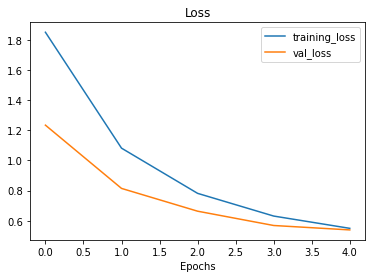

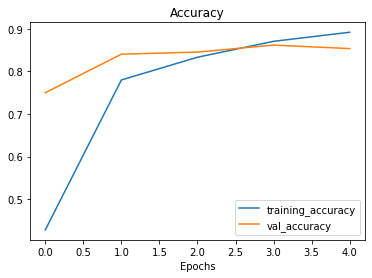

In [ ]:
plot_loss_curves(history_10_percent)

In [ ]:
# Define input tesnor shapr (same number of dimensions as the output of efficientnetb0)

input_shape=(1,4,4,3)

# create a radnom tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tesnor: \n {input_tensor}\n")

# Pass the random tesnor through a global average pooling 2D layer

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tesnor:\n {global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tesnor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tesnor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [ ]:


# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"



--2022-11-06 19:03:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M  24.1MB/s    in 6.5s    

2022-11-06 19:03:26 (19.6 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [ ]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

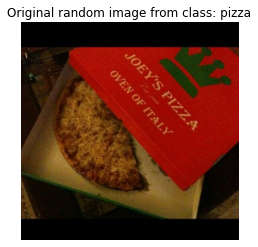

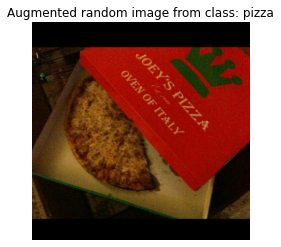

In [ ]:
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# Model 1 Feature extraction transfer learning on 1% of the data with data augmentation
input_shape= (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable= False

# Create an input layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Add in data augumentation sequential model as layer

x = data_augmentation(inputs)

# Give base_model inputs (after aug) and don't train it
x = base_model(x, training=False)

# Pool output feature of base model

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the mdoel

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221106-190330
Epoch 1/5
3/3 [==============================] - 10s 2s/step - loss: 2.4188 - accuracy: 0.1286 - val_loss: 2.2366 - val_accuracy: 0.2039
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1711 - accuracy: 0.2429 - val_loss: 2.1040 - val_accuracy: 0.2730
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9712 - accuracy: 0.4714 - val_loss: 2.0050 - val_accuracy: 0.3289
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7481 - accuracy: 0.6143 - val_loss: 1.9070 - val_accuracy: 0.3931
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6508 - accuracy: 0.6714 - val_loss: 1.7845 - val_accuracy: 0.4819


In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 1.8085 - accuracy: 0.4556


[1.808549404144287, 0.45559999346733093]

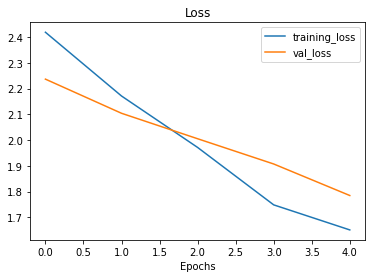

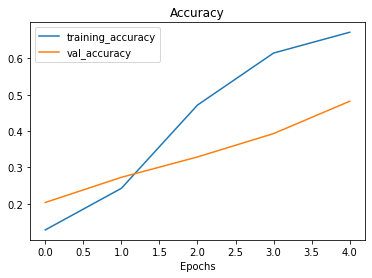

In [ ]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

In [ ]:
# 10 percent data experiment
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
IMG_SIZE=(224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode ="categorical",
                                                               image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
data_augmentation=Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
    # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name="data_augmentation")

# Setup the inpout shape to our model

input_shape=(224,224,3)

# Create a frozen base model

base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and ouput layers 

inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layers")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2=tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.001),
                metrics=["accuracy"])

In [ ]:
# set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch",
                                                        verbose=1)

In [ ]:
# Fit the mdoel saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data = test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback]
                                          )

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221106-190413
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9833 - accuracy: 0.3427
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 467ms/step - loss: 1.9833 - accuracy: 0.3427 - val_loss: 1.4467 - val_accuracy: 0.6645
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3036 - accuracy: 0.6920
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 332ms/step - loss: 1.3036 - accuracy: 0.6920 - val_loss: 1.0142 - val_accuracy: 0.7812
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.7773
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 370ms/step - loss: 0.9898 - accuracy: 0.7773 - val_loss: 0.7976 - val_accuracy: 0.8273
Epo

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug



79/79 [==============================] - 6s 74ms/step - loss: 0.6194 - accuracy: 0.8440


[0.619407594203949, 0.843999981880188]

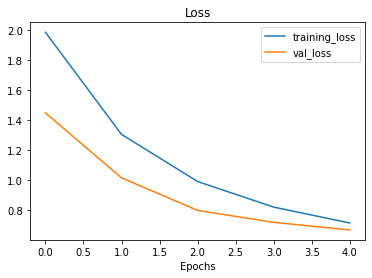

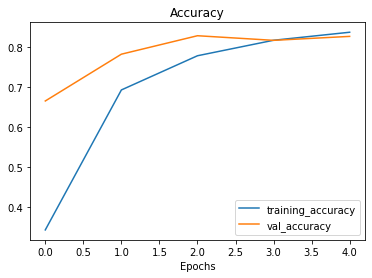

In [ ]:


# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)



In [ ]:
# Load in saved model weights and evaluate model

model_2.load_weights(checkpoint_path)
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6194 - accuracy: 0.8440


In [ ]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Model 3 Fine tuning an existing model on 10% of the data

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [ ]:
model_2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 rs (GlobalAveragePooling2D)                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# How many layers are trainable in our base model

print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustment to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_9 False
1 rescaling_8 False
2 normalization_8 False
3 tf.math.truediv_8 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
# fine tune for another 5 epochs
fine_tune_epochs=initial_epochs + 5

history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data,
                                             initial_epoch=history_10_percent_data_aug.epoch[-1],
                                             validation_steps=int(0.25*len(test_data)),
                                             callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20221106-191015
Epoch 5/10
24/24 [==============================] - 19s 477ms/step - loss: 0.6117 - accuracy: 0.8160 - val_loss: 0.5157 - val_accuracy: 0.8372
Epoch 6/10
24/24 [==============================] - 9s 351ms/step - loss: 0.5175 - accuracy: 0.8373 - val_loss: 0.5004 - val_accuracy: 0.8322
Epoch 7/10
24/24 [==============================] - 10s 394ms/step - loss: 0.4217 - accuracy: 0.8733 - val_loss: 0.4853 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 8s 337ms/step - loss: 0.3890 - accuracy: 0.8773 - val_loss: 0.4614 - val_accuracy: 0.8520
Epoch 9/10
24/24 [==============================] - 8s 336ms/step - loss: 0.3520 - accuracy: 0.8960 - val_loss: 0.4664 - val_accuracy: 0.8322
Epoch 10/10
24/24 [==============================] - 9s 366ms/step - loss: 0.3407 - accuracy: 0.9133 - val_loss: 0.4384 - val_accuracy: 0.8503


In [ ]:
# Evaluate the model
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 75ms/step - loss: 0.4201 - accuracy: 0.8624


In [ ]:


def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()



5
11
[0.3426666557788849, 0.6919999718666077, 0.7773333191871643, 0.8159999847412109, 0.8360000252723694, 0.8159999847412109, 0.8373333215713501, 0.8733333349227905, 0.8773333430290222, 0.8960000276565552, 0.9133333563804626]


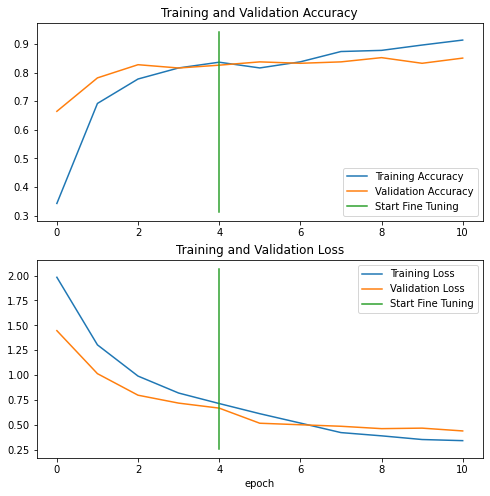

In [ ]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

In [ ]:


# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"



--2022-11-06 19:14:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  22.6MB/s    in 22s     

2022-11-06 19:15:00 (22.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
IMG_SIZE= (224, 224)
train_data_10_classes_full=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4201 - accuracy: 0.8624


[0.42009565234184265, 0.8623999953269958]

In [ ]:
# Load weights from checkpoint, that way we can fin-tune from the sam estage the 10 percent model was fine tuned
model_2.load_weights(checkpoint_path)

In [ ]:


# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)



79/79 [==============================] - 6s 76ms/step - loss: 0.6194 - accuracy: 0.8440


[0.6194076538085938, 0.843999981880188]

In [ ]:


# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug



[0.619407594203949, 0.843999981880188]

In [ ]:


# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)



0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layers True
4 output_layer True


In [ ]:


# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20221106-195158
Epoch 5/10
235/235 [==============================] - 65s 243ms/step - loss: 0.6566 - accuracy: 0.7888 - val_loss: 0.3384 - val_accuracy: 0.8947
Epoch 6/10
235/235 [==============================] - 52s 219ms/step - loss: 0.5252 - accuracy: 0.8293 - val_loss: 0.2644 - val_accuracy: 0.9161
Epoch 7/10
235/235 [==============================] - 49s 206ms/step - loss: 0.4629 - accuracy: 0.8521 - val_loss: 0.2829 - val_accuracy: 0.9128
Epoch 8/10
235/235 [==============================] - 46s 193ms/step - loss: 0.4304 - accuracy: 0.8607 - val_loss: 0.2844 - val_accuracy: 0.9095
Epoch 9/10
235/235 [==============================] - 42s 175ms/step - loss: 0.3933 - accuracy: 0.8727 - val_loss: 0.2549 - val_accuracy: 0.9161
Epoch 10/10
235/235 [==============================] - 41s 172ms/step - loss: 0.3683 - accuracy: 0.8797 - val_loss: 0.2451 - val_accuracy: 0.9293


5
11
[0.3426666557788849, 0.6919999718666077, 0.7773333191871643, 0.8159999847412109, 0.8360000252723694, 0.7888000011444092, 0.8293333053588867, 0.8521333336830139, 0.8606666922569275, 0.8726666569709778, 0.8797333240509033]


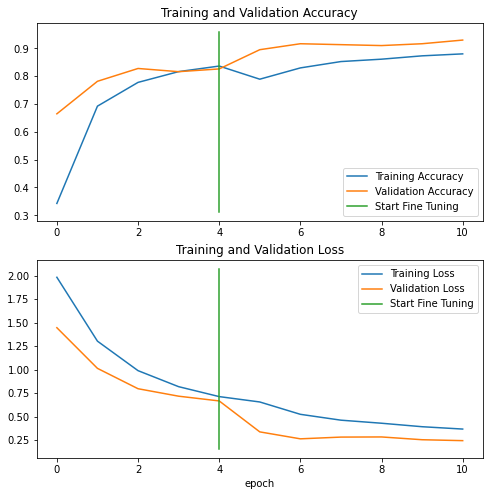

In [ ]:


# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)



In [ ]:


# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished




***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=DKlsw3MkBnoFGroBTnCfEKH4Cams1R&prompt=consent&access_type=o

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/r3qfYu9bTkmqXCz6KFOtmA/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   r3qfYu9bTkmqXCz6KFOtmA
	Created              2022-11-06 20:01:30 (30 seconds ago)
	Updated              2022-11-06 20:01:48 (12 seconds ago)
	Runs                 20
	Tags                 5
	Scalars              312
	Tensor bytes         0
	Binary object bytes  8645148
Total: 1 experiment(s)


In [ ]:
!tensorboard dev delete --experiment_id r3qfYu9bTkmqXCz6KFOtmA

Deleted experiment r3qfYu9bTkmqXCz6KFOtmA.
